In [1]:
import pandas as pd
import pickle
import os
import numpy as np
# data = pickle.load(open('../data/leftppgecg.p','rb'))
directory = '../data_users/ecg_ppg/'
dfs = []
for f in os.listdir(directory)[:30]:
    if f[-1]!='p':
        continue
    a = pickle.load(open(directory+f,'rb'))
    print(a.shape,end=',')
    dfs.append(a)
print()
data1 = pd.concat(dfs)

(13795, 9),(749834, 9),(368771, 9),(176841, 9),(163746, 9),(3735, 9),(418936, 9),(2197624, 9),(261043, 9),(736018, 9),(168070, 9),(397584, 9),(149789, 9),(61073, 9),(3878512, 9),(22212, 9),(162492, 9),(1647772, 9),(640693, 9),(406487, 9),(118743, 9),(464421, 9),(293265, 9),(80632, 9),(1107286, 9),(65821, 9),(934462, 9),(696047, 9),(603317, 9),(445127, 9),


In [2]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features

from copy import deepcopy
data_all = deepcopy(data1)

data_all['red_rr'] = data_all['ppg_rr'].apply(lambda x:x[0])
data_all['ir_rr'] = data_all['ppg_rr'].apply(lambda x:x[1])
data_all['green_rr'] = data_all['ppg_rr'].apply(lambda x:x[2])
data_all['red_qual'] = data_all['likelihood'].apply(lambda x:x[0])
data_all['ir_qual'] = data_all['likelihood'].apply(lambda x:x[1])
data_all['green_qual'] = data_all['likelihood'].apply(lambda x:x[2])
data_all['index'] = data_all['likelihood'].apply(lambda x:np.argmax(np.array(x)))
values = data_all[['ppg_rr','index']].values
values = [a[b] for a,b in values]
data_all['ppg_rr_best'] = values
data_all['likelihood_best'] = data_all['likelihood'].apply(lambda x:max(x))

In [3]:
import pickle
pickle.dump(data_all,open('../data_users/merged_data.p','wb'),protocol=4)

In [13]:
data_all = pickle.load(open('../data_users/merged_data.p','rb'))

In [14]:
def get_data1(a):
    features = []
    ecg_rr = a[:,-1]
    if len(ecg_rr[np.isnan(ecg_rr)])>40:
        return [],[],[],[],[],[]
    m = np.mean(ecg_rr[ecg_rr>0])
    s = np.std(ecg_rr[ecg_rr>0])
    ecg_rr[np.isnan(ecg_rr)] = 0
    if len(ecg_rr)<60:
        return [],[],[],[],[],[]
    y = []
    X = []
    ecg = []
    means = []
    stds = []
    quals = []
    for i in [-2]:
        ppg_rr = a[:,i]
        ppg_qual = a[:,i-4]
#         index = ppg_rr>0
#         ppg_qual = ppg_qual[index]
#         ppg_rr = ppg_rr[index]
        index = np.isnan(ppg_rr)
        index1 = ~np.isnan(ppg_rr)
        if len(ppg_rr[index1])<10:
            continue
        ppg_qual[index] = -1
        ppg_rr[index] = np.nanmean(ppg_rr)
        y.append(ppg_rr.reshape(1,60,1))
        tmp = a[:,np.array([-2,-6,1])].reshape(1,60,3)
        tmp[np.isnan(tmp)] = 0
        tmp[tmp==0] = 0
        X.append(tmp)
        means.append(m)
        stds.append(s)
        ecg.append(ecg_rr.reshape(1,60,1))
        quals.append(ppg_qual.reshape(1,60,1))
#         for j in np.linspace(0,.9,20):
#             index = ppg_qual>j
#             ppg_qual = ppg_qual[index]
#             ppg_rr = ppg_rr[index]
#             if len(ppg_rr)<10:
#                 continue
#             f = list(get_time_domain_features(ppg_rr).values())
#             f1 = list(get_time_domain_features(ecg_rr).values())
#             q = [np.percentile(ppg_qual,20),np.median(ppg_qual),len(ppg_rr)/60]
#             features.append(np.array(f1+f+q))
    return X,y,ecg,means,stds,quals

unique_users = data_all['user'].unique()

def get_data(name,df):
    df = df[['time','activity','red_qual','ir_qual','green_qual','likelihood_best',
             'red_rr','ir_rr','green_rr','ppg_rr_best','ecg_rr']].values
    return df.reshape(-1,60,11)
all_X = []
for user in unique_users:
    data_user = data_all[data_all.user.isin([user])]
    data_user.set_index('timestamp',inplace=True)
    convert_dict = {'ecg_rr': float}
    data_user = data_user.astype(convert_dict) 
    data_resampled = data_user.resample('1S').mean()
    if 'ecg_rr' not in np.array(data_resampled.columns.values):
        continue
    df_col = Parallel(n_jobs=20,verbose=1)(delayed(get_data)(group_name, df_group) for group_name, df_group
                                           in data_resampled.groupby(pd.Grouper(freq='60S')) if df_group.shape[0]==60)
#     df_col = [get_data(group_name, df_group) for group_name, df_group
#                                            in data_resampled.groupby(pd.Grouper(freq='60S')) if df_group.shape[0]==60]
    df_user = np.concatenate(df_col)
    df_col = Parallel(n_jobs=20,verbose=1)(delayed(get_data1)(a) for a in df_user if len(a[~np.isnan(a[:,-1]),-1])>20)    
    all_X.extend(df_col)
    print(user)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  11 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 202 out of 241 | elapsed:    3.9s remaining:    0.7s
[Parallel(n_jobs=20)]: Done 241 out of 241 | elapsed:    3.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 182 out of 182 | elapsed:    0.5s finished


44514a20-82cf-45ee-8fae-828f2ec4f035


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 4600 tasks      | elapsed:    3.9s
[Parallel(n_jobs=20)]: Done 10200 tasks      | elapsed:    7.6s
[Parallel(n_jobs=20)]: Done 17400 tasks      | elapsed:   12.8s
[Parallel(n_jobs=20)]: Done 19305 out of 19305 | elapsed:   14.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   8 out of  23 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=20)]: Done  23 out of  23 | elapsed:    0.1s finished


3133920d-164a-48e6-8d9e-79e919c45d43


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.5s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.9s
[Parallel(n_jobs=20)]: Done 11645 out of 11645 | elapsed:   11.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 1104 out of 1104 | elapsed:    1.3s finished


72cc0041-a4a9-4194-b1e3-bf8e829c5eee


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 3224 out of 3224 | elapsed:    2.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    0.0s finished


c5e2565c-3956-43f4-9b83-4e9a0bd1a0d0


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.6s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    9.0s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   13.1s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   17.8s
[Parallel(n_jobs=20)]: Done 24600 tasks      | elapsed:   23.3s
[Parallel(n_jobs=20)]: Done 31400 tasks      | elapsed:   29.8s
[Parallel(n_jobs=20)]: Done 39000 tasks      | elapsed:   37.3s
[Parallel(n_jobs=20)]: Done 40766 out of 40766 | elapsed:   38.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.7s
[Parallel(n_jo

c1b4671b-623b-42b9-a216-42d57ba8cc61


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   7 out of   7 | elapsed:    0.0s finished


d058f876-d943-4cb0-8e07-540dabb1d7f6


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 608 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 4600 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done 7800 tasks      | elapsed:    6.0s
[Parallel(n_jobs=20)]: Done 7932 out of 7932 | elapsed:    6.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 1459 out of 1459 | elapsed:    1.6s finished


099b45df-6432-47d2-8332-a8a870ec79de


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.4s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.8s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   12.9s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   17.8s
[Parallel(n_jobs=20)]: Done 20658 out of 20658 | elapsed:   19.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  74 out of 113 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 113 out of 113 | elapsed:    0.3s finished


f2bdd151-3fb8-497a-8380-a2b65dc01c2c


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    3.0s
[Parallel(n_jobs=20)]: Done 4433 out of 4433 | elapsed:    4.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 202 out of 202 | elapsed:    0.3s finished


c1895fe4-14ca-4433-95c1-3430fc4c8c35


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 324 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 1324 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 2724 tasks      | elapsed:    4.2s
[Parallel(n_jobs=20)]: Done 4524 tasks      | elapsed:    6.7s
[Parallel(n_jobs=20)]: Done 6724 tasks      | elapsed:    9.6s
[Parallel(n_jobs=20)]: Done 9324 tasks      | elapsed:   13.2s
[Parallel(n_jobs=20)]: Done 12324 tasks      | elapsed:   17.5s
[Parallel(n_jobs=20)]: Done 12460 out of 12499 | elapsed:   17.6s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 12499 out of 12499 | elapsed:   17.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   0 out of   0 | elapsed:    0.0s finished


e79e7e79-93ea-49bf-85ce-c174492c8a14


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 2892 out of 2892 | elapsed:    2.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:    0.0s finished


2c68bc6e-7756-4e00-9a7b-face9ba98cec


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.5s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.9s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   12.9s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   17.7s
[Parallel(n_jobs=20)]: Done 20073 out of 20073 | elapsed:   19.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 1860 out of 1860 | elapsed:    1.6s finished


b71b2071-6330-434d-a2ab-8e929e9b96a9


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    3.0s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.7s
[Parallel(n_jobs=20)]: Done 6905 out of 6905 | elapsed:    7.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 924 out of 924 | elapsed:    0.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


37ab3c6b-092a-494d-a9b8-9f961e9d008a


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 1049 out of 1049 | elapsed:    1.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   0 out of   0 | elapsed:    0.0s finished


eccf2bea-169d-4dce-a9b9-93b4e0c7be83


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 4600 tasks      | elapsed:    4.0s
[Parallel(n_jobs=20)]: Done 10200 tasks      | elapsed:    7.9s
[Parallel(n_jobs=20)]: Done 17400 tasks      | elapsed:   12.7s
[Parallel(n_jobs=20)]: Done 21883 out of 21883 | elapsed:   15.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 647 out of 647 | elapsed:    0.9s finished


0dbd4034-a57f-4056-a8a1-e0d6ba8fdd93


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 4600 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done 6051 out of 6051 | elapsed:    4.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


59ae4c3e-e2d1-4cba-b314-92656fe65360


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 2807 out of 2807 | elapsed:    3.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    0.0s finished


a8c3335f-fd55-40d0-b6e8-08423e67ad22


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.4s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.8s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   12.9s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   18.0s
[Parallel(n_jobs=20)]: Done 21844 out of 21844 | elapsed:   21.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 1660 tasks      | elapsed:    1.7s
[Parallel(n_jobs=20)]: Done 1826 out of 1826 | elapsed:    1.9s finished


8008f00d-2549-46e4-ab1f-01542c1076e2


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 4600 tasks      | elapsed:    3.9s
[Parallel(n_jobs=20)]: Done 10200 tasks      | elapsed:    7.9s
[Parallel(n_jobs=20)]: Done 17400 tasks      | elapsed:   12.7s
[Parallel(n_jobs=20)]: Done 20161 out of 20161 | elapsed:   14.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 1059 out of 1059 | elapsed:    1.2s finished


4ddc3405-d256-4f66-95df-2b13bf69a616


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    3.0s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.6s
[Parallel(n_jobs=20)]: Done 7084 out of 7084 | elapsed:    7.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   0 out of   0 | elapsed:    0.0s finished


8d3b24b0-a89e-4ff2-aee2-8f7f67e2798c


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2313 out of 2313 | elapsed:    2.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 323 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 417 out of 417 | elapsed:    0.9s finished


460a483c-21fc-4ef6-a44a-740d43b81ed4


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 4600 tasks      | elapsed:    3.9s
[Parallel(n_jobs=20)]: Done 10200 tasks      | elapsed:    7.6s
[Parallel(n_jobs=20)]: Done 14084 out of 14084 | elapsed:   10.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 744 out of 744 | elapsed:    1.1s finished


b0f051e0-69ef-4153-9a1e-22ed921d76c3


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 616 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 2616 tasks      | elapsed:    3.1s
[Parallel(n_jobs=20)]: Done 5416 tasks      | elapsed:    5.8s
[Parallel(n_jobs=20)]: Done 9016 tasks      | elapsed:    9.3s
[Parallel(n_jobs=20)]: Done 15832 tasks      | elapsed:   14.4s
[Parallel(n_jobs=20)]: Done 16744 out of 16744 | elapsed:   15.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 276 out of 315 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 315 out of 315 | elapsed:    0.6s finished


0b4bce96-dccb-434b-b4ca-63c7fcd3a7fa


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 1343 out of 1343 | elapsed:    1.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   0 out of   0 | elapsed:    0.0s finished


bc40ffe4-1ec1-4add-bd8b-beb10e727783


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 2920 tasks      | elapsed:    3.0s
[Parallel(n_jobs=20)]: Done 8520 tasks      | elapsed:    7.2s
[Parallel(n_jobs=20)]: Done 15720 tasks      | elapsed:   12.0s
[Parallel(n_jobs=20)]: Done 20098 out of 20098 | elapsed:   14.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 6710 tasks      | elapsed:    2.3s
[Parallel(n_jobs=20)]: Done 6991 out of 6991 | elapsed:    3.3s finished


8d96c9a4-a13b-4729-adf3-969e84b9a6d2


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 1114 out of 1114 | elapsed:    1.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 142 out of 142 | elapsed:    0.3s finished


bba69ab9-3b12-45c1-997e-f64909174649


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    3.1s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.7s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    9.2s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   13.3s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   18.4s
[Parallel(n_jobs=20)]: Done 20699 out of 20699 | elapsed:   20.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.1s finished


522a66a7-1502-46fe-bce4-9e022c52219f


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.3s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.7s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   12.8s
[Parallel(n_jobs=20)]: Done 13891 out of 13891 | elapsed:   13.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 2260 tasks      | elapsed:    1.9s
[Parallel(n_jobs=20)]: Done 2404 out of 2404 | elapsed:    2.0s finished


98fca87c-9940-4666-9893-9f8ae2418cb8


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 616 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2616 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 5416 tasks      | elapsed:    5.6s
[Parallel(n_jobs=20)]: Done 9016 tasks      | elapsed:    8.9s
[Parallel(n_jobs=20)]: Done 13416 tasks      | elapsed:   13.2s
[Parallel(n_jobs=20)]: Done 18616 tasks      | elapsed:   18.1s
[Parallel(n_jobs=20)]: Done 19332 out of 19332 | elapsed:   18.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 4600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 4938 out of 4938 | elapsed:    2.8s finished


87877961-b2f8-4256-806b-973fbd798920


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.5s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    9.0s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   13.3s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   18.3s
[Parallel(n_jobs=20)]: Done 19908 out of 19908 | elapsed:   19.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 624 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 5262 tasks      | elapsed:    2.2s


bde40f50-8e35-4707-8260-b69f07773c4d


[Parallel(n_jobs=20)]: Done 5510 out of 5510 | elapsed:    2.5s finished


In [15]:
X,y,ecg,means,stds,quals = [],[],[],[],[],[]
for a in all_X:
    if len(a[0])==0:
        continue
    X.extend(a[0])
    y.extend(a[1])
    ecg.extend(a[2])
    means.extend(a[3])
    stds.extend(a[4])
    quals.extend(a[5])

In [16]:
import pickle
pickle.dump([X,y,ecg,means,stds,quals],open('../data_users/processed_data.p','wb'),protocol=4)

In [17]:
X,y,ecg,means,stds,quals = np.concatenate(X),np.concatenate(y).reshape(-1,60),np.concatenate(ecg).reshape(-1,60),\
np.array(means).reshape(-1,1),np.array(stds).reshape(-1,1),np.concatenate(quals)

In [18]:
from keras.layers import Input, LSTM, RepeatVector,Bidirectional,Multiply,multiply,Permute
from keras.layers import TimeDistributed,Dense,Flatten,Reshape,Lambda,Activation,GRU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
from keras import metrics,losses
import tensorflow as tf
# import tensorflow_probability as tfp
X_train, X_test, y_train, y_test,ecg_train, \
ecg_test,means_train,means_test,stds_train,stds_test, \
quals_train,quals_test= train_test_split(
    X, y,ecg,means,stds,quals, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val,means_train,means_val,stds_train,stds_val = train_test_split(
    X_train, y_train,means_train,stds_train, test_size=0.2, random_state=42)
print(X.shape,y.shape,y_val.shape,means_val.shape,stds_val.shape)

(33237, 60, 3) (33237, 60) (4454, 60) (4454, 1) (4454, 1)


In [20]:
def output_of_lambda(input_shape):
    return (input_shape[0], 1)

def mean(x):
    return K.mean(x, axis=1, keepdims=True)

def output_of_lambda1(input_shape):
    return (input_shape[0], 1)

def mean1(x):
    return K.std(x, axis=1, keepdims=True)

timesteps = 60
input_dim = 3
latent_dim = 20
output_dim = 1
n = 1
inputs = Input(shape=(timesteps, input_dim))
# inputs2 = Reshape((1,1))(inputs1)
encoded = Bidirectional(GRU(60,return_sequences=True,activation='relu',go_backwards=True))(inputs)
# encoded = LSTM(output_dim,return_sequences=True,activation='sigmoid')(encoded)
att = Dense(1,activation='relu')(encoded)

att = Flatten()(att)
att = Activation(activation="softmax")(att)
att = RepeatVector(120)(att)
att = Permute((2,1))(att)
mer = multiply([att, encoded])

encoded = TimeDistributed(Dense(20,activation='relu'))(mer)
encoded = Flatten()(encoded)
# encoded = Dense(10,activation='relu',name='sequence1')(encoded)
encoded = Dense(60,activation='relu',name='sequence')(encoded)
# encoded = Reshape((60),name='sequence')(encoded)
# encoded_std = K.std(encoded,axis=1)
decoded = Lambda(mean, output_shape=output_of_lambda,name='mean')(encoded)
decoded1 = Lambda(mean1, output_shape=output_of_lambda1,name='std')(encoded)
# decoded = LSTM(output_dim*60, return_sequences=True)(decoded)
# decoded = LSTM(output_dim*3, return_sequences=True)(decoded)
# decoded = LSTM(output_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs=[inputs], outputs=[encoded,decoded,decoded1])
# encoder = Model(inputs, encoded)
losses = {
    "std":"logcosh",
    "mean": "logcosh",
    "sequence": "mae"
}
lossWeights = {"mean": 1, "sequence": 1,"std":1}
# initialize the optimizer and compile the model

sequence_autoencoder.compile(optimizer='adam',loss=losses, loss_weights=lossWeights)

sequence_autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 60, 3)        0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 60, 120)      23040       input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 60, 1)        121         bidirectional_2[0][0]            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 60)           0           dense_3[0][0]                    
____________________________________________________________________________________________

In [21]:
filepath = '../models/base_LSTM.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)
callbacks_list = [es,checkpoint]
history = sequence_autoencoder.fit(X_train, [y_train,means_train,stds_train],
                epochs=300,
                batch_size=500,
                shuffle=True,
                validation_data=(X_val,[y_val,means_val,stds_val]),callbacks=callbacks_list)

Train on 17814 samples, validate on 4454 samples
Epoch 1/300
17814/17814 [==============================] - 8s 476us/step - loss: 1420.4644 - sequence_loss: 682.1417 - mean_loss: 707.8102 - std_loss: 27.7236 - val_loss: 1117.2430 - val_sequence_loss: 541.3840 - val_mean_loss: 550.9597 - val_std_loss: 24.8214

Epoch 00001: val_loss improved from inf to 1117.24304, saving model to ../models/base_LSTM.hdf5
Epoch 2/300
17814/17814 [==============================] - 8s 423us/step - loss: 561.8818 - sequence_loss: 291.5706 - mean_loss: 234.3023 - std_loss: 34.0933 - val_loss: 373.1782 - val_sequence_loss: 213.2397 - val_mean_loss: 139.1022 - val_std_loss: 20.8201

Epoch 00002: val_loss improved from 1117.24304 to 373.17823, saving model to ../models/base_LSTM.hdf5
Epoch 3/300
17814/17814 [==============================] - 8s 424us/step - loss: 357.5929 - sequence_loss: 205.7932 - mean_loss: 131.8696 - std_loss: 19.7874 - val_loss: 347.2275 - val_sequence_loss: 198.9856 - val_mean_loss: 128.4

17814/17814 [==============================] - 8s 423us/step - loss: 318.2735 - sequence_loss: 187.4988 - mean_loss: 111.6651 - std_loss: 19.2088 - val_loss: 316.5625 - val_sequence_loss: 186.3708 - val_mean_loss: 110.9959 - val_std_loss: 19.1604

Epoch 00025: val_loss improved from 318.29687 to 316.56250, saving model to ../models/base_LSTM.hdf5
Epoch 26/300
17814/17814 [==============================] - 7s 421us/step - loss: 318.8293 - sequence_loss: 187.8701 - mean_loss: 111.9432 - std_loss: 19.1501 - val_loss: 324.2941 - val_sequence_loss: 188.3644 - val_mean_loss: 116.6316 - val_std_loss: 19.2830

Epoch 00026: val_loss did not improve from 316.56250
Epoch 27/300
17814/17814 [==============================] - 8s 422us/step - loss: 330.8321 - sequence_loss: 192.9903 - mean_loss: 117.9866 - std_loss: 19.5951 - val_loss: 318.5977 - val_sequence_loss: 186.3381 - val_mean_loss: 113.1152 - val_std_loss: 19.1295

Epoch 00027: val_loss did not improve from 316.56250
Epoch 28/300
17814/1781

17814/17814 [==============================] - 7s 420us/step - loss: 307.6470 - sequence_loss: 178.4305 - mean_loss: 107.3877 - std_loss: 21.7764 - val_loss: 304.0386 - val_sequence_loss: 176.2865 - val_mean_loss: 107.0112 - val_std_loss: 20.7358

Epoch 00050: val_loss improved from 306.05583 to 304.03863, saving model to ../models/base_LSTM.hdf5
Epoch 51/300
17814/17814 [==============================] - 7s 420us/step - loss: 306.1164 - sequence_loss: 177.1819 - mean_loss: 107.2809 - std_loss: 21.5286 - val_loss: 301.9305 - val_sequence_loss: 173.9788 - val_mean_loss: 106.4521 - val_std_loss: 21.5192

Epoch 00051: val_loss improved from 304.03863 to 301.93055, saving model to ../models/base_LSTM.hdf5
Epoch 52/300
17814/17814 [==============================] - 7s 417us/step - loss: 305.1673 - sequence_loss: 175.9154 - mean_loss: 107.4476 - std_loss: 21.8765 - val_loss: 304.7534 - val_sequence_loss: 175.0107 - val_mean_loss: 107.3152 - val_std_loss: 22.4460

Epoch 00052: val_loss did no

17814/17814 [==============================] - 7s 419us/step - loss: 286.1588 - sequence_loss: 157.3589 - mean_loss: 104.0301 - std_loss: 24.6398 - val_loss: 284.8222 - val_sequence_loss: 153.7553 - val_mean_loss: 104.5625 - val_std_loss: 26.5180

Epoch 00074: val_loss did not improve from 284.67045
Epoch 75/300
17814/17814 [==============================] - 7s 420us/step - loss: 285.4906 - sequence_loss: 156.4367 - mean_loss: 104.4001 - std_loss: 24.8766 - val_loss: 304.4122 - val_sequence_loss: 160.9625 - val_mean_loss: 110.9794 - val_std_loss: 32.4786

Epoch 00075: val_loss did not improve from 284.67045
Epoch 76/300
17814/17814 [==============================] - 7s 419us/step - loss: 286.6311 - sequence_loss: 156.6149 - mean_loss: 104.4869 - std_loss: 25.5540 - val_loss: 284.6745 - val_sequence_loss: 154.7925 - val_mean_loss: 105.5243 - val_std_loss: 24.3555

Epoch 00076: val_loss did not improve from 284.67045
Epoch 77/300
17814/17814 [==============================] - 7s 419us/st

17814/17814 [==============================] - 7s 419us/step - loss: 278.5059 - sequence_loss: 145.8257 - mean_loss: 103.3031 - std_loss: 29.4763 - val_loss: 276.8072 - val_sequence_loss: 144.8537 - val_mean_loss: 103.8625 - val_std_loss: 28.0886

Epoch 00099: val_loss improved from 277.37500 to 276.80716, saving model to ../models/base_LSTM.hdf5
Epoch 100/300
17814/17814 [==============================] - 7s 419us/step - loss: 276.8777 - sequence_loss: 144.9028 - mean_loss: 102.6537 - std_loss: 29.2747 - val_loss: 275.5227 - val_sequence_loss: 142.3466 - val_mean_loss: 102.8581 - val_std_loss: 30.3209

Epoch 00100: val_loss improved from 276.80716 to 275.52269, saving model to ../models/base_LSTM.hdf5
Epoch 101/300
17814/17814 [==============================] - 7s 419us/step - loss: 276.1881 - sequence_loss: 143.9354 - mean_loss: 102.5225 - std_loss: 29.7349 - val_loss: 275.3387 - val_sequence_loss: 141.4702 - val_mean_loss: 102.6351 - val_std_loss: 31.2357

Epoch 00101: val_loss impr

17814/17814 [==============================] - 7s 420us/step - loss: 274.6122 - sequence_loss: 141.6907 - mean_loss: 101.6781 - std_loss: 31.3442 - val_loss: 273.6203 - val_sequence_loss: 139.0571 - val_mean_loss: 101.8985 - val_std_loss: 32.6636

Epoch 00124: val_loss improved from 274.03516 to 273.62029, saving model to ../models/base_LSTM.hdf5
Epoch 125/300
17814/17814 [==============================] - 7s 417us/step - loss: 275.2081 - sequence_loss: 142.1162 - mean_loss: 101.7385 - std_loss: 31.3834 - val_loss: 276.5632 - val_sequence_loss: 145.5538 - val_mean_loss: 101.9213 - val_std_loss: 29.0810

Epoch 00125: val_loss did not improve from 273.62029
Epoch 126/300
17814/17814 [==============================] - 7s 417us/step - loss: 276.0159 - sequence_loss: 142.7690 - mean_loss: 102.1017 - std_loss: 31.2358 - val_loss: 274.1759 - val_sequence_loss: 138.2782 - val_mean_loss: 101.6122 - val_std_loss: 34.2894

Epoch 00126: val_loss did not improve from 273.62029
Epoch 127/300
17814/1

17814/17814 [==============================] - 7s 419us/step - loss: nan - sequence_loss: nan - mean_loss: nan - std_loss: nan - val_loss: nan - val_sequence_loss: nan - val_mean_loss: nan - val_std_loss: nan

Epoch 00152: val_loss did not improve from 273.41542
Epoch 153/300
17814/17814 [==============================] - 7s 420us/step - loss: nan - sequence_loss: nan - mean_loss: nan - std_loss: nan - val_loss: nan - val_sequence_loss: nan - val_mean_loss: nan - val_std_loss: nan

Epoch 00153: val_loss did not improve from 273.41542
Epoch 154/300
17814/17814 [==============================] - 8s 422us/step - loss: nan - sequence_loss: nan - mean_loss: nan - std_loss: nan - val_loss: nan - val_sequence_loss: nan - val_mean_loss: nan - val_std_loss: nan

Epoch 00154: val_loss did not improve from 273.41542
Epoch 155/300
17814/17814 [==============================] - 7s 417us/step - loss: nan - sequence_loss: nan - mean_loss: nan - std_loss: nan - val_loss: nan - val_sequence_loss: nan -

In [22]:
from keras.models import load_model
sequence_autoencoder = load_model(filepath)

In [23]:
y_pred1 = sequence_autoencoder.predict(X_test)
y_pred = y_pred1[0]
mean_pred = y_pred1[1]
stds_pred = y_pred1[2]

In [24]:
y_pred1[0].shape,y_pred1[1].shape,y_pred1[2].shape

((10969, 60), (10969, 1), (10969, 1))

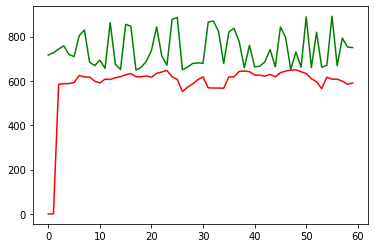

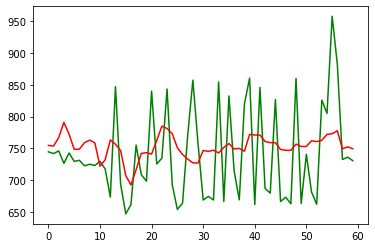

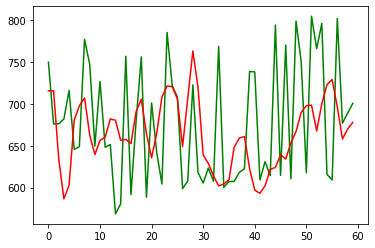

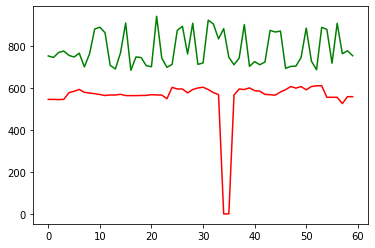

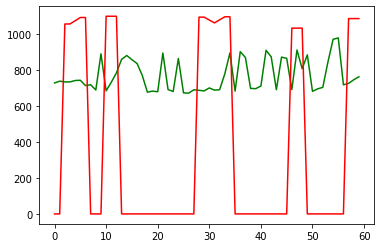

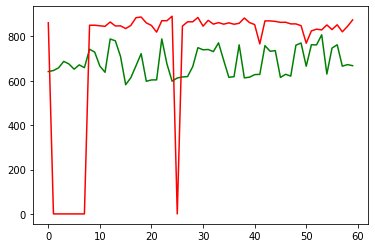

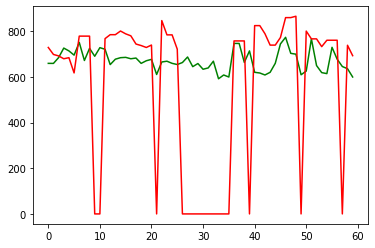

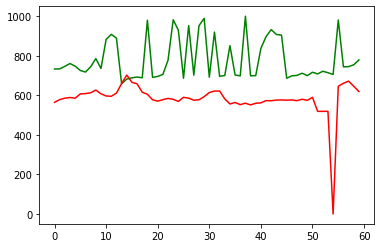

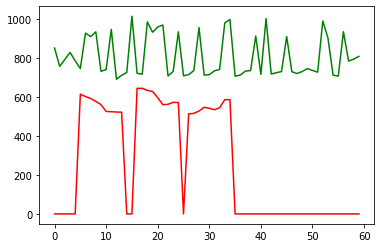

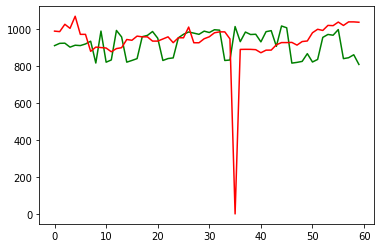

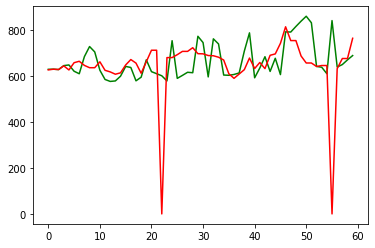

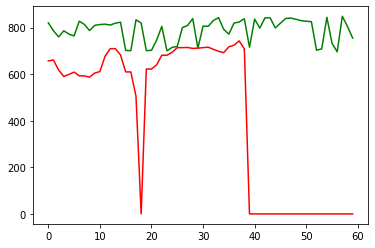

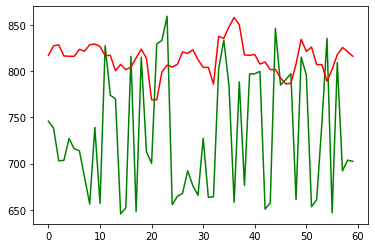

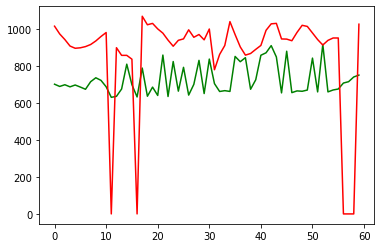

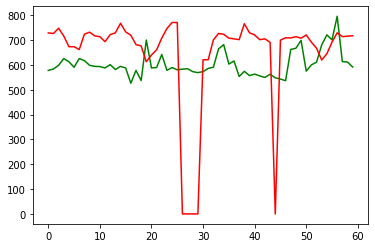

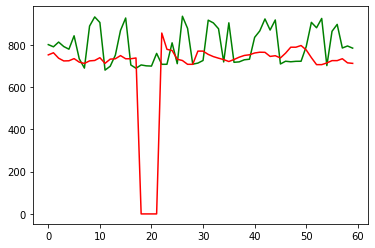

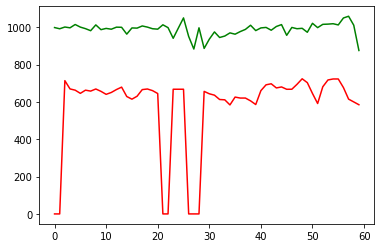

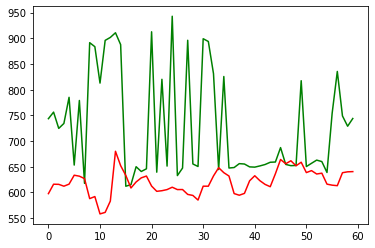

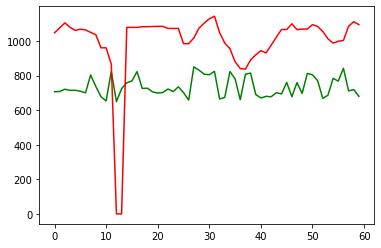

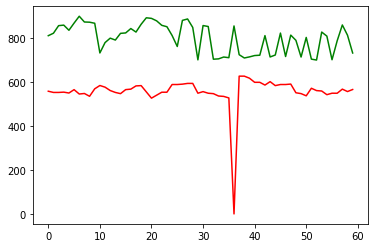

In [25]:
%matplotlib  inline
import matplotlib.pyplot as plt
# plt.plot(y[-10])
for i,a in enumerate(y_pred[::-1][20:40]):
#     if np.sum(a)>0:
    plt.figure()
    plt.plot(a,'g')
#         plt.plot(X[i,:,:],'r')
#     plt.plot(y_test[i],'b')
    plt.plot(ecg_test[i],'r')
    plt.show()

In [31]:
X = np.zeros((len(quals_test.reshape(-1)),4))
X[:,0] = quals_test.reshape(-1)
X[:,1] = y_pred.reshape(-1)
X[:,2] = ecg_test.reshape(-1)
X[:,3] = y_test.reshape(-1)

In [32]:
X = X[X[:,0]>-1]
X = X[X[:,2]>0]
X = X[X[:,3]>0]


(array([195942.,  76902.,  44627.,  35631.,  31725.,  27788.,  25136.,
         24147.,  24668.,  54374.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

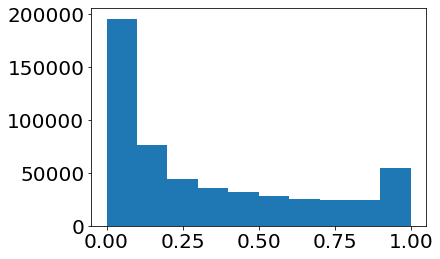

In [33]:
plt.hist(X[:,0])

(116640, 4) 0.0
(79302, 4) 0.05
(46271, 4) 0.1
(30631, 4) 0.15000000000000002
(23908, 4) 0.2
(20462, 4) 0.25
(18545, 4) 0.30000000000000004
(17086, 4) 0.35000000000000003
(16460, 4) 0.4
(15265, 4) 0.45
(14173, 4) 0.5
(13615, 4) 0.55
(12730, 4) 0.6000000000000001
(12583, 4) 0.65
(12146, 4) 0.7000000000000001
(12179, 4) 0.75
(12494, 4) 0.8
(12515, 4) 0.8500000000000001
(15448, 4) 0.9
(27496, 4) 0.9500000000000001
20 20


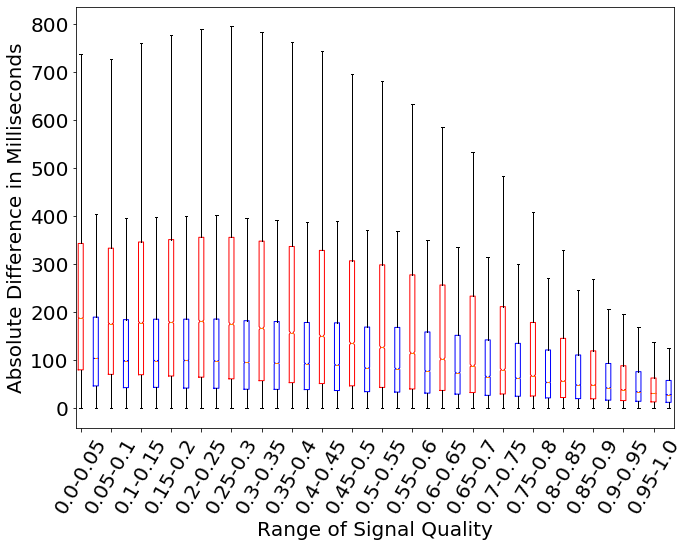

In [51]:
l_range = np.arange(0,1,.05)
x = []
y = []
y1 = []
for l in l_range:
    index = np.where((X[:,0]>=l)&(X[:,0]<l+.05))[0]
    temp = X[index]
    print(temp.shape,l)
    x.append(str(np.round(l*100)/100)+'-'+str(np.round((l+.05)*100)/100))
    y.append(list(np.abs(temp[:,2]-temp[:,3])))
    a = np.array(np.abs(temp[:,1]-temp[:,2]))
    y1.append(a[~np.isnan(a)])
print(len(y),len(y1))
#     print(np.mean(np.abs(temp[:,0]-temp[:,2])),np.std(np.abs(temp[:,0]-temp[:,2])),len(index))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size':20})
c = plt.boxplot(y,showfliers=False,positions=np.array(range(0,3*len(y),3)),notch=True)
for box in c['boxes']:
    box.set(color='red', linewidth=1)
b = plt.boxplot(y1,showfliers=False,positions=np.array(range(0,3*len(y),3))+1.5,notch=True)
for box in b['boxes']:
    box.set(color='blue', linewidth=1)
#     box.set(facecolor = 'red' )
plt.xticks(np.array(range(0,3*len(y),3)),x,rotation=60)
plt.ylabel('Absolute Difference in Milliseconds')
plt.xlabel('Range of Signal Quality')
plt.tight_layout()
plt.show()   

In [ ]:
from hrvanalysis import get_time_domain_features
x = []
y = []
z = []
q = []
s = 'median_nni'
for i in range(ecg_test.shape[0]):
    qual_min = quals_test[i].reshape(-1)
    qual_min = qual_min[qual_min>-1]
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    ecg_min= ecg_min[~np.isnan(ecg_min)]
    y_pred_min = y_pred[i].reshape(-1)
    y_pred_min = y_pred_min[~np.isnan(y_pred_min)]
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[y_test_min>0]
    y_test_min = y_test_min[~np.isnan(y_test_min)]
    if len(ecg_min)<10 or len(y_pred_min)<5 or len(y_test_min)<5:
        continue
    x.append(get_time_domain_features(y_pred_min)[s])
    y.append(get_time_domain_features(ecg_min)[s])
    z.append(get_time_domain_features(y_test_min)[s])
    q.append(np.median(qual_min))
    if np.isinf(x[-1]) or np.isinf(y[-1]) or np.isinf(z[-1]) or np.isinf(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
    elif np.isnan(x[-1]) or np.isnan(y[-1]) or np.isnan(z[-1]) or np.isnan(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
#     print(np.std(ecg_min),np.std(y_test_min),np.std(y_pred_min),np.median(qual_min))
    
    

In [ ]:
from scipy.stats import pearsonr,spearmanr
q,x,y,z = np.array(q),np.array(x),np.array(y),np.array(z)
for i in np.linspace(0,.9,10):
    index = np.where((q>=i)&(q<=i+.1))[0]
    if len(index)<2:
        continue
    print(pearsonr(x[index],y[index]),pearsonr(y[index],z[index]),i,i+.1,len(index))

In [ ]:
# plt.hist(y.reshape(-1),50)
plt.hist(y_pred.reshape(-1),50)
plt.hist(ecg_test.reshape(-1),50)

In [ ]:
np.std(y[0].reshape(1,-1,1),axis=1)

In [ ]:
plt.plot(y_pred1[1].reshape(-1),means_test.reshape(-1),'*')

In [ ]:
from scipy.stats import pearsonr
pearsonr(y_pred1[1].reshape(-1),means_test.reshape(-1))

In [ ]:
import keras

In [ ]:
keras.__version__

In [ ]:
y_pred.reshape(-1).shape

In [ ]:
t = y_pred.reshape(-1)

In [ ]:
t[np.isfinite(t)].shape

(array([  4484.,      0.,      0.,      0.,      0., 343920.,  93727.,
         68662.,  56865.,  90482.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

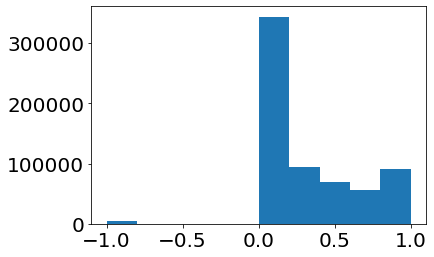

In [30]:
plt.hist(quals_test.reshape(-1))